# Approximating Implicit Matrix Factorization with Shallow Neural Networks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/Users/willwolf/Documents/willwolf/dotify


# resources
- https://arxiv.org/pdf/1606.07674.pdf

In [3]:
# delete this eventually

import os

os.environ['SQLALCHEMY_DATABASE_URI'] = os.environ['DIGITAL_OCEAN_SQLALCHEMY_DATABASE_URI']

In [4]:
from collections import namedtuple
from copy import deepcopy
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine

from dotify.config import DevelopmentConfig as Config
from dotify.recommendation.implicit_mf.ratings_matrix import RatingsMatrix
from dotify.recommendation.implicit_mf.implicit_mf import ImplicitMF
from dotify.resources.countries import countries as countries_lookup

ENGINE = create_engine(Config.SQLALCHEMY_DATABASE_URI)

%matplotlib inline
plt.style.use('seaborn')

# Abstract

## Implicit Matrix Factorization

The Implicit Matrix Factorization (IMF) algorithm as presented by [Hu, Koren and Volinksy](http://yifanhu.net/PUB/cf.pdf) is a widely popular, effective method for recommending items to users. This approach was born from necessity: while explicit feedback as to our users' tastes - a questionnaire completed at user signup, for example - makes building a recommendation engine straightforward, we often have nothing more than *implicit feedback* data - view count, click count, time spent on page, for example - which serve as nothing more than a proxy for these preferences. Crucially, the latter feedback is asymmetric: while a high view count might indicate positive preference for a given item, a low view count cannot be said to do the opposite. Perhaps, the user simply doesn't know the item is there.

IMF begins with a ratings matrix $R$, where $R_{u, i}$ gives the implicit feedback value observed for user $u$ and item $i$. Next, it constructs two other matrices defined as follows:

$$
p_{u, i} =
\begin{cases}
1 & r_{u, i} \gt 0\\
0 & r_{u, i} = 0
\end{cases}
$$
<br>
$$
c_{u, i} = 1 + \alpha r_{u, i}
$$

$P$ gives a binary matrix indicating our belief in the existence of each user's preference for each item. $C$ gives our *confidence* in the existence of each user's preference for each items where, trivially, larger values of $r_{u, i}$ give us higher confidence that user $u$ indeed likes item $i$.

Next, IMF outlines its goal: let's embed each user and item into $\mathbb{R}^f$ such that their dot product approximates the former's true preference for the latter. Finally, and naming user vectors $x_u \in \mathbb{R}^f$ and item vectors $y_i \in \mathbb{R}^f$, we compute the argmin of the following objective:

$$
\underset{x_{*}, y_{*}}{\arg\min}\sum\limits_{u, i}c_{u, i}\big(p_{u, i} - x_u^Ty_i\big)^2 + \lambda\bigg(\sum\limits_u\|x_u\|^2 + \sum\limits_i\|y_u\|^2\bigg)
$$

Once sufficiently minimized, we can compute expected preferences $\hat{p}_{u, i} = x_u^Ty_i$ for unobserved $\text{(user, item)}$ pairs; recommendation then becomes:
1. For a given user $u$, compute predicted preferences $\hat{p}_{u, i} = x_u^Ty_i$ for all items $i$.
2. Sort the list in descending order.
3. Returning the top $n$ items.

## Shallow neural networks
IMF effectively gives a function $f: u, i \rightarrow \hat{p}_{u, i}$. As before, our goal is to minimize the function above, which we can now rewrite as:

$$
\underset{x_{*}, y_{*}}{\arg\min}\sum\limits_{u, i}c_{u, i}\big(p_{u, i} - f(u, i)\big)^2 + \lambda\bigg(\sum\limits_u\|x_u\|^2 + \sum\limits_i\|y_u\|^2\bigg)
$$

To approximate this function, I turn to our favorite [universal function approximator](http://neuralnetworksanddeeplearning.com/chap4.html): neural networks optimized with gradient descent.

This work is built around a toy web application I authored long ago: [dotify](http://dotify.herokuapp.com/). At present, dotify:
- Pulls data nightly from [Spotify Charts](https://spotifycharts.com/regional). These data contain the number of streams for that day's top 200 songs for each of 55 countries.
- Computes an implicit matrix factorization nightly, giving vectors for both countries and songs.
- Allows the user to input a "country-arithmetic" expression, i.e. "I want music like `Colombia x Turkey - Germany`." It then performs this arithmetic with the chosen vectors and recommends songs to the composite.

In this work, I first fit and cross-validate an implicit matrix factorization model, establishing the three requisite parameters: $f$, the dimensionality of the latent vectors; $\alpha$, the scalar multiple used in computing $C$; $\lambda$ the regularization strength used in on our loss function.

### Network architectures

Next, I explore five different shallow neural network architectures in attempt to improve upon the observed results. These architectures are as follows:

1. A trivially "Siamese" network which first embeds each country and song index into $\mathbb{R}^f$ in parallel then computes a dot-product of the embeddings. This is roughly equivalent to what is being done by IMF.
2. Same as previous, but with a bias embedding for each set, in $\mathbb{R}$, added to the dot-product.
3. Same as [#1](#network_1), but concatenate the vectors instead. Then, stack 3 fully-connected layers with ReLU activations, batch normalization after each, and dropout after the first. Finally, add a 1-unit dense layer on the end, and add bias embeddings to the result. (NB: I wanted to add the bias embeddings to the respective $\mathbb{R}^f$ embeddings at the outset, but couldn't figure out how to do this in Keras.)
4. Same as [#2](#network_2), except feed in the song title text as well. This text is first tokenized, then padded to a maximum sequence length, then embedded into a fixed-length vector by an LSTM, then reduced to a single value by a dense layer with a ReLU activation. Finally, this scalar is concatenated to the scalar output that [#2](#network_2) would produce, and the result is fed into a final dense layer with a linear activation - i.e. a linear combination of the two.
5. Same as [#4](#network_4), except feed in the song artist index as well. This index is first embedded into a vector, then reduced to a scalar by a dense layer with a ReLu activation. Finally, this scalar is concatenated with the two scalars produced in the second-to-last layer of [#4](#network_4), then fed into a final dense layer with a linear activation. Like the previous, this is a linear combination of the three inputs.

# add the links in here

# Results

# Data preparation

To construct our ratings matrix, I take the sum of total streams for each $\text{(country, song)}$ pair. The data are limited to a given number of "top songs," defined as a song that appeared on Spotify Charts *on a given date*.

Because the values exist on wildly different orders of magnitude, I scale the results as follows:

$$\tilde{r}_{u, i} = \log{\bigg(\frac{1 + r_{u, i}}{\epsilon}\bigg)}$$

To start, let's build a ratings matrix for a small sample of the data.

In [143]:
ratings_matrix = RatingsMatrix(n_top_songs=10000, eps=1e3)
ratings_matrix.R_ui.head()

song_id,5552,5553,5557,5558,5560,5562,5565,5582,5583,5585,...,33062,33064,33065,33066,33067,33068,33069,33070,33071,33072
country_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,3.643437,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.546472,0.0,0.0,3.597833,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.0,3.175760,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,1.138153,0.961264,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's get an idea of the sparsity of our data and how many songs each country has streamed.

In [144]:
sparsity = (ratings_matrix.R_ui == 0).mean().mean()
non_zero_entries_percent = 100*np.round(1 - sparsity, 4)

print('Our ratings matrix has {}% non-zero entries.'.format(non_zero_entries_percent))

Our ratings matrix has 7.3999999999999995% non-zero entries.


In [145]:
print('Our ratings matrix contains {} countries and {} unique songs.'.format(*ratings_matrix.R_ui.shape))

Our ratings matrix contains 55 countries and 2110 unique songs.


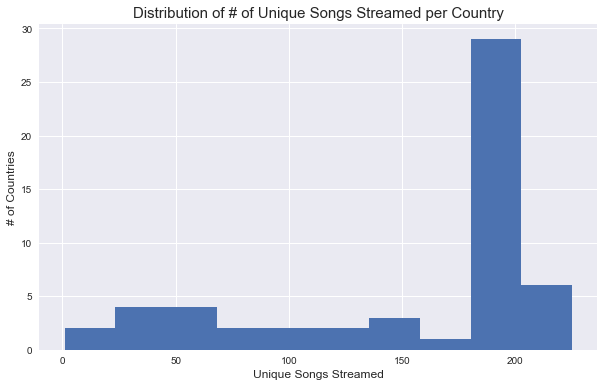

In [146]:
plt.figure(figsize=(10, 6))

songs_rated_by_country = (ratings_matrix.R_ui > 0).sum(axis=1)
plt.hist(songs_rated_by_country)
plt.title('Distribution of # of Unique Songs Streamed per Country', fontsize=15)
plt.xlabel('Unique Songs Streamed', fontsize=12)
_ = plt.ylabel('# of Countries', fontsize=12)

## Construct training, validation sets

In reviewing literature on recommender engine evaluation, it seems common to create training and validation sets as follows:
1. Filter your ratings matrix for users (countries) that meet some criterion, i.e. they've streamed above a certain threshold of songs.
2. Select a random $x\%$ of their items (songs).
3. "Move" these items into a validation matrix; set them to 0 in the training matrix.

To construct this split, I first compute a sensible threshold for Step #1, then "move" a random 20% of songs from the training matrix to the validation matrix.

In [147]:
print('The 15th percentile of songs rated by country is {}.'.format(
    np.percentile(songs_rated_by_country, 15)
))

The 15th percentile of songs rated by country is 54.5.


Let's choose 50 as our cutoff, and move 20% of the songs in qualifying rows to a validation set.

NB: The actual ratings matrix is located at `RatingsMatrix.R_ui`. This reflects the API choice I made when first starting this project.

In [12]:
def split_ratings_matrix_into_training_and_validation(ratings_matrix, eligibility_mask, fraction_to_drop=.2):
    training_matrix = ratings_matrix
    validation_matrix = deepcopy(training_matrix)
    validation_matrix.R_ui = pd.DataFrame(0., index=training_matrix.R_ui.index, columns=training_matrix.R_ui.columns)

    for country_id, ratings in training_matrix.R_ui[eligibility_mask].iterrows():
        
        rated_songs_mask = training_matrix.R_ui.ix[country_id] > 0
        rated_songs = training_matrix.R_ui.ix[country_id][rated_songs_mask].index.tolist()
        n_songs_to_drop = int( len(rated_songs)*fraction_to_drop )
        songs_to_drop = set( random.sample(rated_songs, n_songs_to_drop) )
        
        validation_matrix.R_ui.ix[country_id][songs_to_drop] = training_matrix.R_ui.ix[country_id][songs_to_drop]
        training_matrix.R_ui.ix[country_id][songs_to_drop] = 0.

    return training_matrix, validation_matrix

In [152]:
more_than_50_ratings_mask = songs_rated_by_country > 50

training_matrix, validation_matrix = split_ratings_matrix_into_training_and_validation(
    ratings_matrix=ratings_matrix, 
    eligibility_mask=more_than_50_ratings_mask
)

# Evaluation

Evaluating recommender systems is an inexact science because there is no "right" answer. In production, this evaluation is often done via the A/B test of a proxy metric important to the business - revenue, for example. In training, the process is less clear. To this end, the authors of the IMF paper offer the following:

> Evaluation of implicit-feedback recommender requires appropriate measures. In the traditional setting where a user is specifying a numeric score, there are clear metrics such as mean squared error to measure success in prediction. However with implicit models we have to take into account availability of the item, competition for the item with other items, and repeat feedback. For example, if we gather data on television viewing, it is unclear how to evaluate a show that has been watched more than once, or how to compare two shows that are on at the same time, and hence cannot both be watched by the user.

Additionally, they state:

> It is important to realize that we do not have a reliable feedback regarding which programs are unloved, as not watching a program can stem from multiple different reasons. In addition, we are currently unable to track user reactions to our recommendations. Thus, precision based metrics are not very appropriate, as they require knowing which programs are undesired to a user. However, watching a program is an indication of liking it, making recall-oriented measures applicable.

In solution, they propose evaluating the "expected percentile ranking" defined as follows:

$$
\overline{\text{rank}} = \frac{\sum_{u, i}\tilde{r}_{u, i}^t\text{rank}_{u, i}}{\sum_{u, i}\tilde{r}_{u, i}^t}
$$

Here, $\text{rank}_{u, i}$ gives the percentile-ranking of the predicted preference, i.e. if $\hat{p}_{u = 17, i = 34}$ is the largest of all predicted preferences, then $\text{rank}_{u = 17, i = 34} = 0\%$. Similarly, the smallest of the predicted preferences, i.e. the last on the list, equals $100\%$.

The following class accepts a training matrix, validation matrix and a matrix of predicted preferences. It then exposes the mean expected percentile ranking for both training and validation sets as properties on the instance.

In [6]:
class ExpectedPercentileRankingsEvaluator:
    
    def __init__(self, training_matrix, validation_matrix, eligibility_mask, predicted_preferences):
        self.training_matrix = training_matrix
        self.validation_matrix = validation_matrix
        self.eligibility_mask = eligibility_mask
        self.predicted_preferences = predicted_preferences
        self._expected_percentile_rankings_train = []
        self._expected_percentile_rankings_validation = []
        
    def run(self):
        self._evaluate_train()
        self._evaluate_validation()

    def _evaluate_train(self):
        self._expected_percentile_rankings_train = self._evaluate(matrix=self.training_matrix)
        
    def _evaluate_validation(self):
        self._expected_percentile_rankings_validation = self._evaluate(matrix=self.validation_matrix)
        
    def _evaluate(self, matrix):
        expected_percentile_rankings = []
        for country_id, preferences in self.predicted_preferences[self.eligibility_mask].iterrows():
            predictions = pd.DataFrame({
                'predicted_preference': preferences.sort_values(ascending=False),
                'rank': np.arange( len(preferences) ),
                'percentile_rank': np.arange( len(preferences) ) / len(preferences)
            })
            ground_truth = matrix.R_ui.ix[country_id][ matrix.R_ui.ix[country_id] > 0 ]
            numerator = (ground_truth * predictions['percentile_rank'][ground_truth.index]).sum()
            denominator = ground_truth.sum()
            expected_percentile_rankings.append( numerator / denominator )

        return expected_percentile_rankings

    @property
    def mean_expected_percentile_rankings_train(self):
        return np.mean(self._expected_percentile_rankings_train)
    
    @property
    def mean_expected_percentile_rankings_validation(self):
        return np.mean(self._expected_percentile_rankings_validation)

## Grid search

Next, we perform a basic grid search to find reasonable values for $\alpha$ and $\lambda$.

In [ ]:
F = 30
grid_search_results = {}
result = namedtuple('Result', 'alpha lmbda')
alpha_values = [1e-1, 1e0, 1e1, 1e2]
lmbda_values = [1e-1, 1e0, 1e1, 1e2]

for alpha in alpha_values:
    for lmbda in lmbda_values:
        implicit_mf = ImplicitMF(ratings_matrix=training_matrix, f=F, alpha=alpha, lmbda=lmbda)
        implicit_mf.run()
        predicted_preferences = implicit_mf.country_vectors.vectors.dot( implicit_mf.song_vectors.vectors.T )
        
        evaluator = ExpectedPercentileRankingsEvaluator(
            training_matrix=training_matrix,
            validation_matrix=validation_matrix,
            eligibility_mask=more_than_50_ratings_mask,
            predicted_preferences=predicted_preferences
        )
        evaluator.run()
        grid_search_results[result(alpha=alpha, lmbda=lmbda)] = {
            'train': evaluator.mean_expected_percentile_rankings_train,
            'validation': evaluator.mean_expected_percentile_rankings_validation
        }
        print(grid_search_results)

Let's visualize the results for clarity. I plot the opposite of the validation score such that the parameters corresponding to the *darkest* square are found to be most favorable.

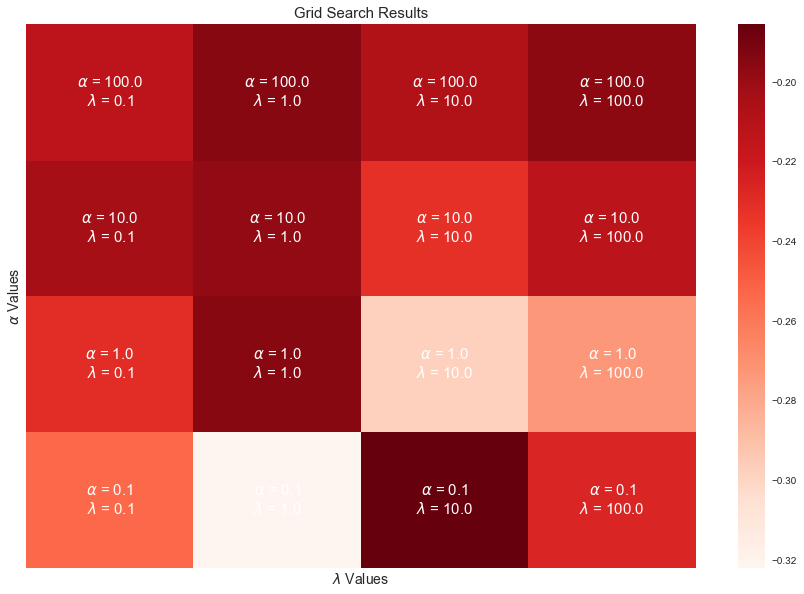

In [159]:
grid_search_items = [(params, results) for params, results in grid_search_results.items()]
grid_search_items.sort(key=lambda tup: tup[0].alpha)

params, results = zip(*grid_search_items)
validation_results = np.array([result['validation'] for result in results]).reshape(4, 4)

plt.figure(figsize=(15, 10))
plt.xticks([])
plt.yticks([])
plt.pcolormesh(-validation_results, cmap='Reds')
plt.colorbar()
for alpha_index, alpha in enumerate(alpha_values):
    for lbmda_index, lmbda in enumerate(lmbda_values):
        plt.text(
            x = lbmda_index + 0.5,
            y = alpha_index + 0.5,
            s = r'$\alpha$ = {}'.format(alpha) + '\n' + r'$\lambda$ = {}'.format(lmbda), 
            ha='center', 
            va='center', 
            size=15, 
            color='w'
        )
plt.title('Grid Search Results', fontsize=15)
plt.xlabel(r'$\lambda$ Values', fontsize=14)
_ = plt.ylabel(r'$\alpha$ Values', fontsize=14)

In [42]:
result = namedtuple('Result', 'alpha lmbda')

grid_search_results = {result(alpha=0.1, lmbda=0.1): {'train': 0.032607841781153155,
  'validation': 0.32187316160294116},
 result(alpha=0.1, lmbda=1.0): {'train': 0.032162052218278323,
  'validation': 0.25351706009764435},
 result(alpha=0.1, lmbda=10.0): {'train': 0.044797203928065049,
  'validation': 0.18543168148626762},
 result(alpha=0.1, lmbda=100.0): {'train': 0.13612215475501488,
  'validation': 0.22614972696578045},
 result(alpha=1.0, lmbda=0.1): {'train': 0.032038543431178533,
  'validation': 0.29772185227695197},
 result(alpha=1.0, lmbda=1.0): {'train': 0.032019139110313607,
  'validation': 0.27294720414633278},
 result(alpha=1.0, lmbda=10.0): {'train': 0.032727505840995437,
  'validation': 0.1948131117257722},
 result(alpha=1.0, lmbda=100.0): {'train': 0.13683466896390581,
  'validation': 0.22982983373921831},
 result(alpha=10.0, lmbda=0.1): {'train': 0.031688407262988348,
  'validation': 0.21223186541520442},
 result(alpha=10.0, lmbda=1.0): {'train': 0.031530429459967833,
  'validation': 0.23133048291896302},
 result(alpha=10.0, lmbda=10.0): {'train': 0.031329205666670856,
  'validation': 0.19754317976386013},
 result(alpha=10.0, lmbda=100.0): {'train': 0.05090529785135077,
  'validation': 0.20353060014601437},
 result(alpha=100.0, lmbda=0.1): {'train': 0.033150692540597458,
  'validation': 0.19600535885100662},
 result(alpha=100.0, lmbda=1.0): {'train': 0.032674738051067,
  'validation': 0.20784556679839028},
 result(alpha=100.0, lmbda=10.0): {'train': 0.03211332197336892,
  'validation': 0.21300816817666413},
 result(alpha=100.0, lmbda=100.0): {'train': 0.032603892117932215,
  'validation': 0.19485982091289744}}


In [58]:
best_params = min(grid_search_results, key=lambda key: grid_search_results.get(key)['validation'])
print('The best parameters were found to be: {}.'.format(best_params))

The best parameters were found to be: Result(alpha=0.1, lmbda=10.0).


# Train a final model

Using the best parameters, let's train a final implicit matrix factorization model using 1,000,000 top songs. Additionally, we'll choose $\epsilon = 1,000$ which seemed to work best in simple experimentation. This work is not shown here.

In [7]:
ratings_matrix = RatingsMatrix(n_top_songs=1000000, eps=1e3)

In [163]:
print('Our ratings matrix contains {} countries and {} unique songs.'.format(*ratings_matrix.R_ui.shape))

Our ratings matrix contains 55 countries and 8663 unique songs.


In [ ]:
implicit_mf = ImplicitMF(ratings_matrix=ratings_matrix, f=F, alpha=best_params.alpha, lmbda=best_params.lmbda)
implicit_mf.run()

# save stuff we care about from the final implicit mf run

In [164]:
# implicit_mf.country_vectors.vectors.to_csv('data/country_vectors.csv')
# implicit_mf.song_vectors.vectors.to_csv('data/song_vectors.csv')
implicit_mf.country_vectors.vectors = pd.read_csv('data/country_vectors.csv', index_col=['country_id'])
implicit_mf.song_vectors.vectors = pd.read_csv('data/song_vectors.csv', index_col=['song_id'])

# Visualize

Let's plot the cosine similarities between all pairs of countries to confirm that things make sense. Intuitively, I'd think that countries in the following groups should be similar:
- United States, United Kingdom, Canada, Australia, New Zealand
- Latin American countries
- Sweden, Finland, Norway, Denmark

First let's replace the index of our vectors such that it contains the country names.

In [165]:
country_vectors_df = implicit_mf.country_vectors.vectors.copy()

country_id_to_name = {countries_lookup[name]['id']: name for name in countries_lookup}
country_ids = country_vectors_df.index
country_names = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
country_vectors_df.index = country_names

country_vectors_df.head()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29
country_name,,,,,,,,,,,,,,,,,,,,,
United States,-1.276051,-1.058583,-0.622779,0.430231,0.306830,0.966786,0.190530,-0.549356,0.538788,-0.722162,...,0.057478,0.500288,0.799253,0.383243,0.575051,0.247066,0.548018,-0.238643,0.114481,0.731294
United Kingdom,0.106521,0.346207,-0.276669,-0.003249,-1.294024,-0.090318,0.666301,-0.533962,0.281620,-0.268332,...,-0.803658,-0.498773,-0.041302,-0.705815,0.624482,-0.007293,1.335080,-0.717667,0.019507,-1.700016
Argentina,-0.871966,0.678408,0.343354,-0.968614,-1.099471,0.014175,0.031833,-0.370821,-0.114270,-0.982766,...,0.435942,-0.170878,-0.172491,-0.158596,0.445267,-0.949628,0.542433,-0.157643,0.765119,0.587947
Australia,-1.129085,0.212391,0.136416,-0.665215,0.452084,-0.418566,-0.187979,0.807976,-0.693282,-0.723989,...,-0.961785,-0.064047,-0.161033,0.211444,0.180285,0.597487,-0.143220,0.336241,-0.251201,-1.057264
Austria,-0.094485,0.870111,-0.328650,-0.594735,-0.429165,-0.955718,0.151173,0.250305,-0.302996,0.718965,...,-0.409435,-0.381884,-0.144373,0.340587,0.006711,0.870717,0.067101,-0.361675,0.742727,1.341254


Then, we'll plot the cosine similarities.

In [166]:
sns.set(style="white")

def plot_cosine_similarities(country_vectors_df):

    similarities_df = pd.DataFrame(
        data=cosine_similarity(country_vectors_df),
        index=country_vectors_df.index,
        columns=country_vectors_df.index
    )
    
    lower_triangle_mask = np.zeros_like(similarities_df, dtype=np.bool)
    lower_triangle_mask[np.triu_indices_from(lower_triangle_mask)] = True

    f, ax = plt.subplots(figsize=(21, 21))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(
        similarities_df, 
        mask=lower_triangle_mask, 
        cmap=cmap, 
        vmax=.5,
        square=True, 
        xticklabels=True, 
        yticklabels=True,
        linewidths=1, 
        cbar_kws={"shrink": .5}, 
        ax=ax,
    )
    ax.set_title('Cosine Similarity Matrix', fontsize=20)

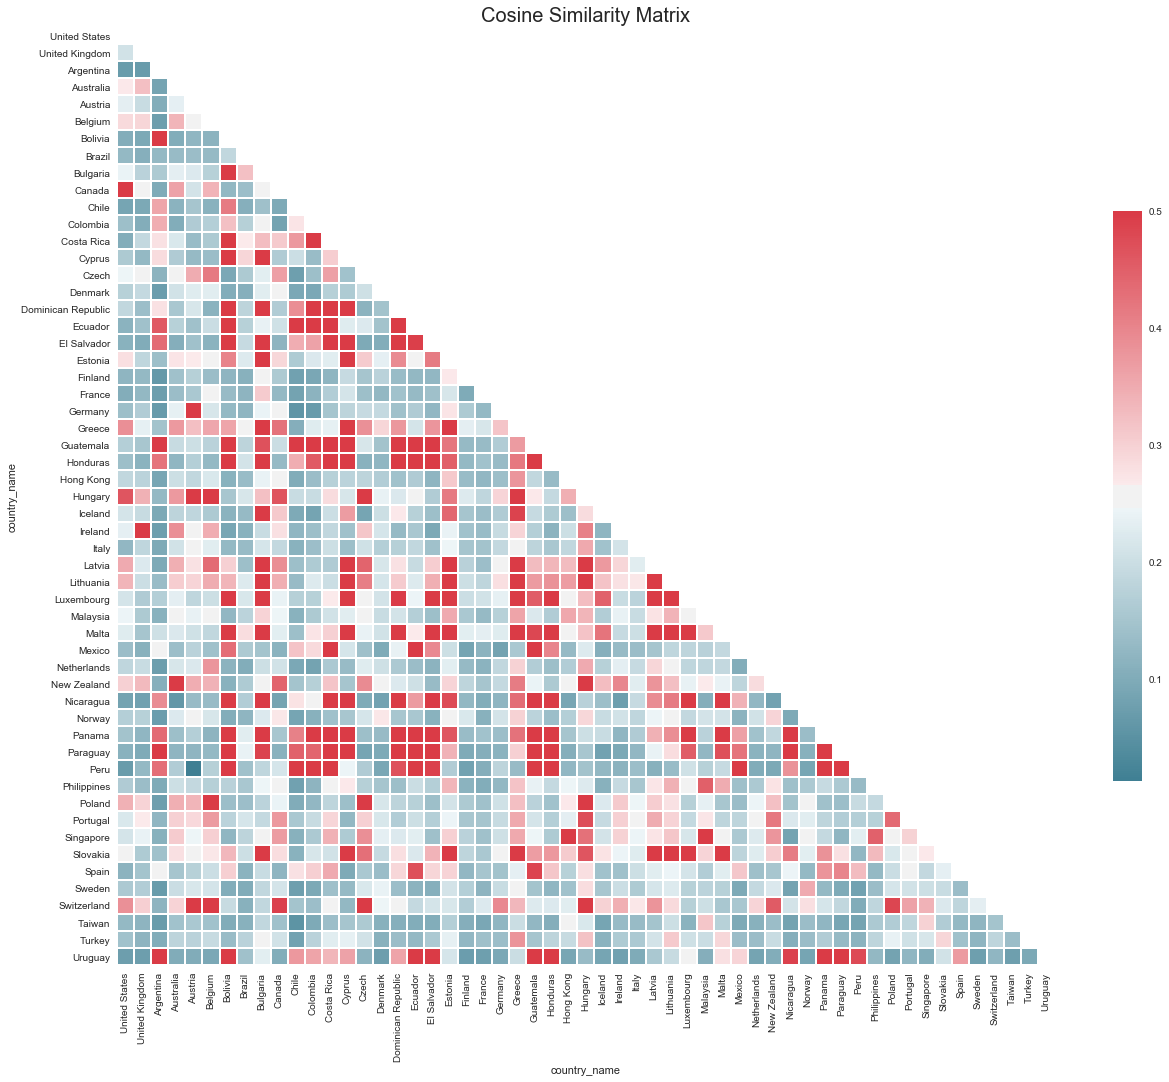

In [167]:
plot_cosine_similarities(country_vectors_df)

I first turn to my favorite country - Colombia - to inspect its similarity with other Latin American countries. The numbers are high for: Peru, Paraguay, Panama, Nicaragua, Gautemala, Ecuador, Dominican Republic and Costa Rica.

Next, I turn to the United Kingdom: it is most similar with Switzerland, New Zealand, Ireland, Hungary, Belgium and Australia.

Finally, we see that Sweden is similar enough to Norway, yet not Finland (who, incidentally, seems to have nothing in common with anyone at all).

Overall, this looks very good to me.

# Visualize with TSNE

To further inspect similarities between countries, let's explore the 2-dimensional TSNE space.

In [205]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=12345)

country_embeddings = pd.DataFrame(
    data=tsne.fit_transform(country_vectors_df),
    index=country_vectors_df.index,
    columns=['dim_1', 'dim_2']
)

In [206]:
def plot_tsne_embeddings(country_embeddings):

    plt.figure(figsize=(15,15))

    for country_name, country_embedding in country_embeddings.iterrows():
        dim_1, dim_2 = country_embedding
        plt.scatter(dim_1, dim_2)
        plt.annotate(country_name, xy=(dim_1, dim_2), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        plt.title('Two-Dimensional TSNE Embeddings of Latent Country Vectors', fontsize=16)
        plt.xlabel('Dimension 1', fontsize=12)
        plt.ylabel('Dimension 2', fontsize=12)
    plt.show()

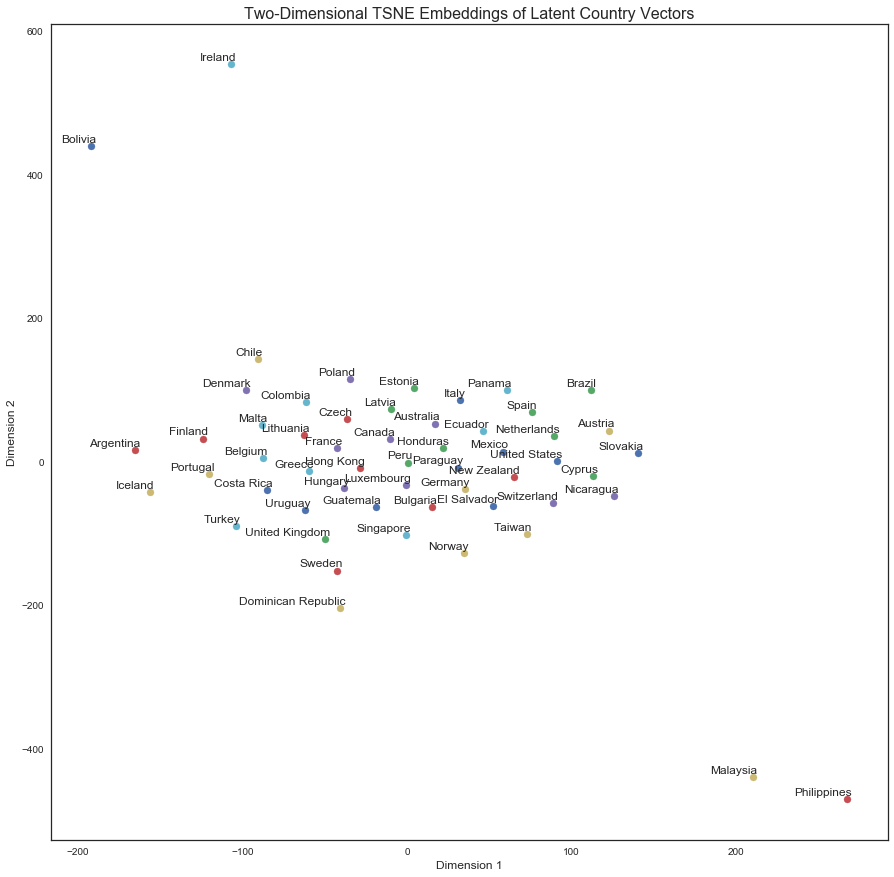

In [207]:
plot_tsne_embeddings(country_embeddings)

This is not particularly useful. Furthermore, and perhaps most importantly, the plot varies immensely when changing the random seed. This is a worthwhile step nonetheless.

# Inspect predicted preferences

Crucially, we'll now inspect predicted preferences for select countries and confirm that they make sense. I first normalize each of the country and song vectors, then computed predicted preferences via the dot product.

In [ ]:
SONG_METADATA_QUERY = """
    SELECT 
        songs.title as song_title, 
        songs.artist as song_artist,
        songs.id as song_id
    FROM songs
"""

song_metadata_df = pd.read_sql(SONG_METADATA_QUERY, ENGINE, index_col=['song_id'])

song_vectors_df = song_metadata_df.join(implicit_mf.song_vectors.vectors, how='inner')\
    .set_index(['song_title', 'song_artist'])

In [209]:
song_vectors_df_norm = song_vectors_df.apply(lambda vec: vec / np.linalg.norm(vec), axis=1)
country_vectors_df_norm = country_vectors_df.apply(lambda vec: vec / np.linalg.norm(vec), axis=1)

assert song_vectors_df_norm.apply(np.linalg.norm, axis=1).mean() == 1.
assert country_vectors_df_norm.apply(np.linalg.norm, axis=1).mean() == 1.

## United States

In [210]:
pd.set_option('display.max_colwidth', 100)

In [211]:
country_vec = country_vectors_df_norm.ix['United States']
song_vectors_df_norm.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Dab of Ranch - Recorded at Spotify Studios NYC,Migos,0.899299
1,Massage In My Room,Future,0.899299
2,Father Stretch My Hands Pt. 1,Kanye West,0.899299
3,Keep On,Kehlani,0.899299
4,First Day Out,Tee Grizzley,0.899299
5,When I Was Broke,Future,0.899299
6,Star Of The Show,Thomas Rhett,0.899299
7,Rose Golden,Kid Cudi,0.899299
8,oui,Jeremih,0.899299
9,Everyday We Lit,YFN Lucci,0.899299


## Colombia

In [212]:
country_vec = country_vectors_df_norm.ix['Colombia']
song_vectors_df_norm.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Ya No Me Duele Más,Silvestre Dangond,0.941204
1,Bajo el agua,Manuel Medrano,0.919997
2,Si No Te Quiere,Ozuna,0.916971
3,El Ganador,Nicky Jam,0.898030
4,"Oiga, Mira, Vea",Guayacán Orquesta,0.897944
5,Mil Lágrimas,Nicky Jam,0.897863
6,Déjame Te Explico,Reykon,0.897396
7,Quédate,Manuel Medrano,0.896307
8,Afuera del planeta,Manuel Medrano,0.895686
9,Materialista,Silvestre Dangond,0.895501


## Turkey

In [213]:
country_vec = country_vectors_df_norm.ix['Turkey']
song_vectors_df_norm.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Dudak,Edis,0.943574
1,Benim Karanlık Yanım,Sezen Aksu,0.943574
2,Affection,Cigarettes After Sex,0.943574
3,Ateş Böceği,Mithat Can Özer,0.943574
4,Beni Öyle Bilme,Ceylan Ertem,0.943574
5,Keyfim Kaçık Acık,Can Bonomo,0.943574
6,Seni Unutmaya Ömrüm Yeter mi,Ümit Besen,0.943574
7,Vazgeçtim,Sezen Aksu,0.943574
8,Yanımda Kal,Harun Kolçak,0.943574
9,Stanga,Sagi Abitbul,0.943574


## Germany

In [214]:
country_vec = country_vectors_df_norm.ix['Germany']
song_vectors_df_norm.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Skandale,Bonez MC,0.908499
1,Ahnma,Beginner,0.906591
2,Am schönsten,SDP,0.906250
3,Tage wie diese,Die Toten Hosen,0.906250
4,Kartell (feat. Azet & Nash),Zuna,0.906250
5,Chill mal dein Leben (feat. Moe Phoenix),Kianush,0.906250
6,Neuanfang,Clueso,0.906250
7,Neben der Spur,Maxwell,0.906250
8,Hochspannung,Maxwell,0.906250
9,Intro,Capital Bra,0.906250


## Taiwan

In [215]:
country_vec = country_vectors_df_norm.ix['Taiwan']
song_vectors_df_norm.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,如果的事,王藍茵,0.954455
1,小小的,思衛,0.954455
2,Heathens (feat. MUTEMATH),Twenty One Pilots,0.954455
3,其實都沒有,楊宗緯,0.954455
4,對摺 - 國語,任賢齊,0.954455
5,最難的是相遇,Valen Hsu,0.954455
6,안녕 못해 I'm Not Okay (From “MISSING 9”),CHEN,0.954455
7,未接來電,楊乃文,0.954455
8,飛機 - feat. 林俊峰,林俊傑,0.954455
9,All On Me,Devin Dawson,0.954455


These look great.

One interesting thing to note is the significance of the length of the vectors. To this point, [Schakel and Wilson](https://arxiv.org/abs/1508.02297) note the following:

> A word that is consistently used in a similar context will be represented by a longer vector than a word of the same frequency that is used in different contexts.

> Not only the direction, but also the length of word vectors carries important information.

> Word vector length furnishes, in combination with term frequency, a useful measure of word significance.

In our case, my guess is that length indicates something like popularity - at least for songs. Let's see which songs and countries have the largest L2 norms.

In [216]:
song_vectors_df.apply(np.linalg.norm, axis=1).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Shape of You,Ed Sheeran,0.687497
1,Starboy,The Weeknd,0.684529
2,"I Don’t Wanna Live Forever (Fifty Shades Darker) - From ""Fifty Shades Darker (Original Motion Pi...",ZAYN,0.682996
3,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.682941
4,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,0.682918
5,Paris,The Chainsmokers,0.682878
6,Call On Me - Ryan Riback Extended Remix,Starley,0.682799
7,Castle on the Hill,Ed Sheeran,0.682442
8,I Feel It Coming,The Weeknd,0.682225
9,Closer,The Chainsmokers,0.682175


In [217]:
country_vectors_df.apply(np.linalg.norm, axis=1).sort_values(ascending=False).reset_index().head(10)

,country_name,0
0,Taiwan,4.842656
1,Sweden,4.602653
2,Finland,4.415459
3,France,4.399233
4,United Kingdom,4.374870
5,Netherlands,4.330190
6,Denmark,4.232457
7,Italy,4.218088
8,Norway,4.084380
9,Germany,4.076692


To reference Taiwan and Colombia, let's inspect predictions using unnormalized vectors.

In [218]:
country_vec = country_vectors_df.ix['Taiwan']
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Bad Things - With Camila Cabello,Machine Gun Kelly,0.958864
1,Just Hold On,Steve Aoki,0.958692
2,Shape of You,Ed Sheeran,0.958325
3,Side To Side,Ariana Grande,0.957497
4,Closer,The Chainsmokers,0.957290
5,Starboy,The Weeknd,0.957090
6,Paris,The Chainsmokers,0.957001
7,"I Don’t Wanna Live Forever (Fifty Shades Darker) - From ""Fifty Shades Darker (Original Motion Pi...",ZAYN,0.956933
8,Something Just Like This,The Chainsmokers,0.956803
9,The Greatest,Sia,0.956746


In [219]:
country_vec = country_vectors_df.ix['Colombia']
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,I Got You,Bebe Rexha,1.019838
1,Party Monster,The Weeknd,0.993647
2,Hello,Adele,0.993421
3,I Would Like,Zara Larsson,0.987099
4,Scars To Your Beautiful,Alessia Cara,0.987036
5,Weak,AJR,0.986642
6,Too Good,Drake,0.982179
7,Nancy Mulligan,Ed Sheeran,0.979373
8,Supermarket Flowers,Ed Sheeran,0.978706
9,Hearts Don't Break Around Here,Ed Sheeran,0.978494


Respectively, there is not a song with Chinese nor Spanish letters in each set of recommendations. Additionally, it seems like the world is fond of Ed Sheeran. It is clear that the global popularity of songs dominates our recommendations when computing the dot product with unnormalized vectors.

When we do normalize, our predicted preferences can be defined thus:

$$
\hat{x}_u = \frac{x_u}{\|x_u\|} \quad \hat{y}_i = \frac{y_i}{\|y_i\|}\\
\hat{p}_{u, i} = \hat{x}_u \cdot \hat{y}_i
$$

One idea might be to scale the song vectors by their respective lengths, leaving our predicted preferences as:

$$
\begin{align*}
\hat{p}_{u, i} &= \hat{x}_u \cdot \big(\hat{y}_i \cdot c\|y_i\|\big)\\
&= \hat{x}_u \cdot \Bigg(\hat{y}_i \cdot c\frac{y_i}{\hat{y_i}}\Bigg)\\
&= \hat{x}_u \cdot c y_i
\end{align*}
$$

Let's briefly see what this looks like.

In [220]:
C = .2

country_vec = country_vectors_df_norm.ix['Taiwan']
(C * song_vectors_df).dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Bad Things - With Camila Cabello,Machine Gun Kelly,0.039601
1,Just Hold On,Steve Aoki,0.039594
2,Shape of You,Ed Sheeran,0.039578
3,Side To Side,Ariana Grande,0.039544
4,Closer,The Chainsmokers,0.039536
5,Starboy,The Weeknd,0.039528
6,Paris,The Chainsmokers,0.039524
7,"I Don’t Wanna Live Forever (Fifty Shades Darker) - From ""Fifty Shades Darker (Original Motion Pi...",ZAYN,0.039521
8,Something Just Like This,The Chainsmokers,0.039516
9,The Greatest,Sia,0.039513


About the same. Nevertheless, the length of our vectors can likely offer some value when balancing local recommendations with globally popular songs. I leave this to the reader to explore further for now.

# Approximating IMF with neural networks

Again, IMF gives a function $f: u, i \rightarrow \hat{p}_{u, i}$ and the following objective function to minimize:

$$
\underset{x_{*}, y_{*}}{\arg\min}\sum\limits_{u, i}c_{u, i}\big(p_{u, i} - f(u, i)\big)^2 + \lambda\bigg(\sum\limits_u\|x_u\|^2 + \sum\limits_i\|y_u\|^2\bigg)
$$

Let's try to do this with neural networks. I'll use our $\alpha$ and $\lambda$ parameters as found above, and keep the same dimensionality, $F = 30$, for our latent vectors. This number was chosen in separate experimentation not shown here.

In [32]:
from itertools import product

from keras import backend as K
from keras.layers import Input, Embedding, Flatten, Lambda, Dense, BatchNormalization, Dropout, LSTM
from keras.layers.merge import add, dot, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils import plot_model

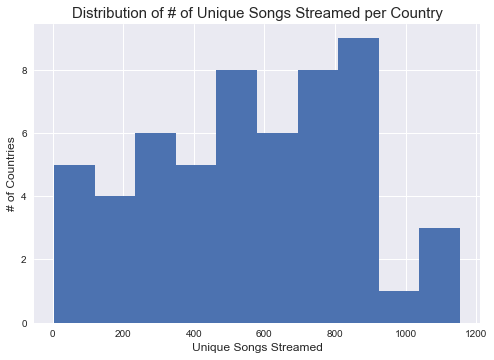

In [9]:
songs_rated_by_country = (ratings_matrix.R_ui > 0).sum(axis=1)

plt.hist(songs_rated_by_country)
plt.title('Distribution of # of Unique Songs Streamed per Country', fontsize=15)
plt.xlabel('Unique Songs Streamed', fontsize=12)
_ = plt.ylabel('# of Countries', fontsize=12)

In [10]:
print('The 15th percentile of songs rated by country is {}.'.format(
    np.percentile(songs_rated_by_country, 15)
))

The 15th percentile of songs rated by country is 218.20000000000002.


Let's pick our eligibility cutoff at 200 songs and create training and validation matrices.

In [13]:
more_than_200_ratings_mask = songs_rated_by_country > 20

training_matrix, validation_matrix = split_ratings_matrix_into_training_and_validation(
    ratings_matrix=ratings_matrix,
    eligibility_mask=more_than_200_ratings_mask
)

## Arrange our data

To interact with Keras, we'll need to change our data from wide format to long. Additionally, so as to create our embeddings, we'll need to give each country and song a unique, contiguous index. Finally, I'll do the same with the song artist, as well as tokenizing the song title, for later use.

In [16]:
song_metadata_df = song_metadata_df.ix[ratings_matrix.R_ui.columns]
song_metadata_df.head()

,song_title,song_artist
song_id,,
5552,El Perdón,Nicky Jam
5553,Lean On (feat. MØ & DJ Snake),Major Lazer
5555,"Love Me Like You Do - From ""Fifty Shades Of Grey""",Ellie Goulding
5556,Uptown Funk,Mark Ronson
5557,Loquita,Marama


In [17]:
country_id_to_index = {c_id: index for index, c_id in enumerate(ratings_matrix.R_ui.index)}
song_id_to_index = {s_id: index for index, s_id in enumerate(ratings_matrix.R_ui.columns)}
song_artist_to_index = {artist: index for index, artist in enumerate(song_metadata_df['song_artist'].unique())}

song_metadata_df['song_index'] = song_metadata_df.index.map(song_id_to_index.get)
song_metadata_df['song_artist_index'] = song_metadata_df['song_artist'].map(song_artist_to_index.get).astype(int)
song_metadata_df.tail()

,song_title,song_artist,song_index,song_artist_index
song_id,,,,
33068,Affection,Cigarettes After Sex,8658,3699
33069,Istemem Soz Sevmeni,Ferman Akgül,8659,3106
33070,Skammekroken 2017,TIX,8660,1677
33071,Wiosna,Organek,8661,3716
33072,Fuckt.,Strapo,8662,3717


### Tokenize song title

In [18]:
NUM_WORDS = 5000

tokenizer = Tokenizer(num_words=NUM_WORDS, lower=True, split=" ")
tokenizer.fit_on_texts(song_metadata_df['song_title'])
song_metadata_df['title_sequence'] = tokenizer.texts_to_sequences(song_metadata_df['song_title'])

### Convert ratings to long format

In [19]:
input_tuples = list( product(ratings_matrix.R_ui.index, ratings_matrix.R_ui.columns) )
country_ids, song_ids = zip(*input_tuples)

ratings_df = pd.DataFrame({
    'country_id': country_ids,
    'song_id': song_ids,
    'train_rating': training_matrix.R_ui.values.flatten(),
    'validation_rating': validation_matrix.R_ui.values.flatten(),
})

ratings_df = ratings_df.join(song_metadata_df, on='song_id', how='inner').sort_index()
ratings_df['country_index'] = ratings_df['country_id'].map(country_id_to_index.get)

## Define network parameters

In [22]:
n_countries = ratings_df['country_index'].nunique()
n_songs = ratings_df['song_index'].nunique()

alpha = best_params.alpha
lmbda = best_params.lmbda
F = 30
LEARNING_RATE = .001

## Define a loss function

This is simply the IMF objective we'd like to minimize.

In [23]:
def implicit_cf_loss(y_true, y_pred, alpha=alpha):
    P = y_true > 0
    C = 1 + alpha*y_true
    return K.mean( C*(P - y_pred)**2 )

## Define functions to generate, evaluate and visualize predictions

In [24]:
def generate_predictions(model, inputs, ratings_df=ratings_df):
    predictions = model.predict(x=inputs)
    return pd.DataFrame({
        'prediction': predictions.flatten(),
        'country_id': ratings_df['country_id'],
        'song_id': ratings_df['song_id']
    }).pivot('country_id', 'song_id', 'prediction')

In [25]:
def evaluate_predictions(predictions, eligibility_mask=more_than_200_ratings_mask, 
                         training_matrix=training_matrix, validation_matrix=validation_matrix):
    evaluator = ExpectedPercentileRankingsEvaluator(
        training_matrix=training_matrix,
        validation_matrix=validation_matrix,
        eligibility_mask=eligibility_mask,
        predicted_preferences=predictions
    )
    evaluator.run()
    print('Train: {}'.format(evaluator.mean_expected_percentile_rankings_train))
    print('Validation: {}'.format(evaluator.mean_expected_percentile_rankings_validation))

In [74]:
def visualize_predictions(predictions):
    plt.figure(figsize=(10, 6))

    plt.hist(predictions.values.flatten(), bins=25)
    plt.title('Predicted Preferences Histogram', fontsize=15)
    plt.xlabel('Predicted Prefence', fontsize=12)
    _ = plt.ylabel('Count', fontsize=12)



5. Same as #4, except feed in the song artist index as well. This index is first embedded into a vector, then reduced to a scalar by a dense layer with ReLu activation. Finally, this scalar is concatenated with the two scalars produced in the second-to-last layer of #4, then fed into a final dense layer with a linear activation. Like the previous, this is a linear combination of the three inputs.

<a id="network_1"></a>
# Network \#1

A trivially "Siamese" network which first embeds each country and song index into $\mathbb{R}^f$ in parallel then computes a dot-product of the embeddings. This is roughly equivalent to what is being done by IMF.

In [162]:
country_input = Input(shape=(1,), dtype='int64', name='country')
song_input = Input(shape=(1,), dtype='int64', name='song')

country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

predicted_preference = dot(inputs=[country_embedding, song_embedding], axes=2)
predicted_preference = Flatten()(predicted_preference)

In [163]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

plot_model(model, to_file='figures/network_1.png')

![](../figures/network_1.png)

In [164]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

network_1 = model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=1024, 
    epochs=5,
    validation_data=(inputs, ratings_df['validation_rating'])
)

Train on 476465 samples, validate on 476465 samples
Epoch 1/5
476465/476465 [==============================] - 2s - loss: 64.9000 - val_loss: 0.0185
Epoch 2/5
476465/476465 [==============================] - 8s - loss: 0.0744 - val_loss: 0.0185
Epoch 3/5
476465/476465 [==============================] - 3s - loss: 0.0744 - val_loss: 0.0185
Epoch 4/5
476465/476465 [==============================] - 10s - loss: 0.0745 - val_loss: 0.0185
Epoch 5/5
476465/476465 [==============================] - 8s - loss: 0.0745 - val_loss: 0.0186


In [165]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

Train: 0.5053388101677021
Validation: 0.49071882278215817


For reference, let's recall the results we computed when validation our model with `best_params`.

In [166]:
grid_search_results[best_params]

{'train': 0.04479720392806505, 'validation': 0.18543168148626762}

Additionally, a *random* model should return an expected percentile ranking of ~50%, as noted in [Hu, Koren and Volinksy](http://yifanhu.net/PUB/cf.pdf). So, this is really bad. Let's visualize the distribution of predictions before moving on to another model.

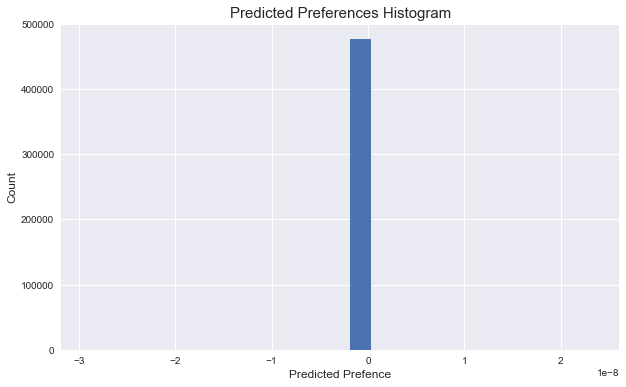

In [167]:
visualize_predictions(predictions)

<a id="network_2"></a>
# Network \#2

Same as previous, but with a bias embedding for each set, in $\mathbb{R}$, added to the dot-product.

In [168]:
country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

predicted_preference = add(inputs=[predicted_preference, song_bias, country_bias])
predicted_preference = Flatten()(predicted_preference)

In [169]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

plot_model(model, to_file='figures/network_2.png')

![](../figures/network_2.png?)

In [170]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

network_2 = model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=1024, 
    epochs=5,
    validation_data=(inputs, ratings_df['validation_rating'])
)

Train on 476465 samples, validate on 476465 samples
Epoch 1/5
476465/476465 [==============================] - 2s - loss: 0.0734 - val_loss: 0.0204
Epoch 2/5
476465/476465 [==============================] - 2s - loss: 0.0563 - val_loss: 0.0216
Epoch 3/5
476465/476465 [==============================] - 2s - loss: 0.0534 - val_loss: 0.0236
Epoch 4/5
476465/476465 [==============================] - 2s - loss: 0.0515 - val_loss: 0.0252
Epoch 5/5
476465/476465 [==============================] - 2s - loss: 0.0502 - val_loss: 0.0269


In [171]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

Train: 0.10900494586591782
Validation: 0.1906236846450195


This looks a lot better. Now let's visualize our ground-truth and predictions side-by-side.

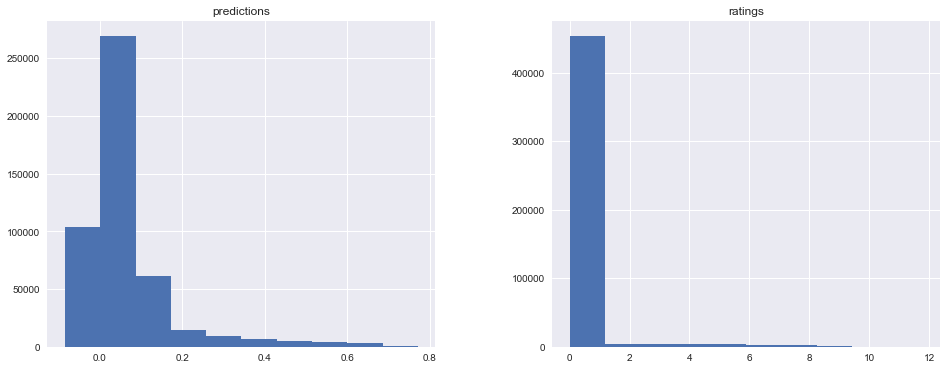

In [172]:
_ = pd.DataFrame({
    'predictions': predictions.values.flatten(),
    'ratings': ratings_df['train_rating'].values.flatten()
}).hist(figsize=(16, 6))

This model approximates the training distribution much better than the others. Key to this task is delineating between items with 0 ratings, and those with high ratings. Remember, we first down-scaled our ratings with the following transformation to shrink the domain:

$$\tilde{r}_{u, i} = \log{\bigg(\frac{1 + r_{u, i}}{\epsilon}\bigg)}$$

Furthermore, the model scores worse on the training distribution, yet similarly on the validation set. The bias term was clearly helpful, and is our first conceptual divergence from IMF - I think.

Let's try a similar model, but *concatenate* the country and song embeddings, then stack fully connected layers, then compute the final linear combination as before.

<a id="network_3"></a>
# Network \#3

Same as [#1](#network_1), but concatenate the latent vectors instead. Then, stack 3 fully-connected layers with ReLU activations, batch normalization after each, and dropout after the first. Finally, add a 1-unit dense layer on the end, and add bias embeddings to the result. (NB: I wanted to add the bias embeddings to the respective $\mathbb{R}^f$ embeddings at the outset, but couldn't figure out how to do this in Keras.)

In [185]:
country_input = Input(shape=(1,), dtype='int64', name='country')
song_input = Input(shape=(1,), dtype='int64', name='song')

country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

concatenation = concatenate([country_embedding, song_embedding])

dense_layer = Dense(activation='relu', units=10)(concatenation)
dropout = Dropout(.5)(dense_layer)
batch_norm = BatchNormalization()(dropout)
dense_layer = Dense(activation='relu', units=10)(batch_norm)
batch_norm = BatchNormalization()(dense_layer)
dense_layer = Dense(activation='relu', units=10)(batch_norm)
batch_norm = BatchNormalization()(dense_layer)

predicted_preference = Dense(units=1, name='predicted_preference')(batch_norm)
predicted_preference = Flatten()(predicted_preference)

predicted_preference = add(inputs=[predicted_preference, country_bias, song_bias])
predicted_preference = Flatten()(predicted_preference)

In [190]:
model = Model(inputs=[country_input, song_input], outputs=predicted_preference)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

plot_model(model, to_file='figures/network_3.png')

![](../figures/network_3.png?)

In [191]:
inputs = [ratings_df['country_index'], ratings_df['song_index']]

network_3 = model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=1024, 
    epochs=5,
    validation_data=(inputs, ratings_df['validation_rating'])
)

Train on 476465 samples, validate on 476465 samples
Epoch 1/5
476465/476465 [==============================] - 5s - loss: 0.0702 - val_loss: 0.0830
Epoch 2/5
476465/476465 [==============================] - 5s - loss: 0.0472 - val_loss: 0.0601
Epoch 3/5
476465/476465 [==============================] - 5s - loss: 0.0477 - val_loss: 0.0667
Epoch 4/5
476465/476465 [==============================] - 5s - loss: 0.0483 - val_loss: 0.0508
Epoch 5/5
476465/476465 [==============================] - 5s - loss: 0.0491 - val_loss: 0.0513


In [192]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

Train: 0.11102242413459021
Validation: 0.1899202531334214


These results are roughly identical to the previous. Choosing between the models, we'd certainly go with the simpler of the two.

Now, let's try some architectures that benefit from other data sources altogether: the song title, and the song artist.

<a id="network_4"></a>
# Network \#4

Same as [#2](#network_2), except feed in the song title text as well. This text is first tokenized, then padded to a maximum sequence length, then embedded into a fixed-length vector by an LSTM, then reduced to a single value by a dense layer with a ReLU activation. Finally, this scalar is concatenated to the scalar output that [#2](#network_2) would produce, and the result is fed into a final dense layer with a linear activation - i.e. a linear combination of the two.

In [194]:
MAX_SEQUENCE_LENGTH = ratings_df['title_sequence'].map(len).max()

padded_title_sequences = pad_sequences(sequences=ratings_df['title_sequence'], maxlen=MAX_SEQUENCE_LENGTH)

In [205]:
country_input = Input(shape=(1,), dtype='int64', name='country')
song_input = Input(shape=(1,), dtype='int64', name='song')
title_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='song_title_sequence')

country_embedding = Embedding(input_dim=n_countries, output_dim=F, embeddings_regularizer=l2(lmbda))(country_input)
song_embedding = Embedding(input_dim=n_songs, output_dim=F, embeddings_regularizer=l2(lmbda))(song_input)
title_embedding = Embedding(output_dim=F, input_dim=NUM_WORDS, input_length=MAX_SEQUENCE_LENGTH)(title_input)

country_bias = Embedding(input_dim=n_countries, output_dim=1, name='country_bias', input_length=1)(country_input)
song_bias = Embedding(input_dim=n_songs, output_dim=1, name='song_bias', input_length=1)(song_input)

predicted_preference = dot(inputs=[country_embedding, song_embedding], axes=2)
predicted_preference = add(inputs=[predicted_preference, country_bias, song_bias])
predicted_preference = Flatten()(predicted_preference)

title_lstm = LSTM(F)(title_embedding)
dense_title_lstm = Dense(units=1, activation='relu')(title_lstm)

predicted_preference_merge = concatenate(inputs=[predicted_preference, dense_title_lstm])
final_output = Dense(activation='linear', units=1)(predicted_preference_merge)

In [206]:
model = Model(inputs=[country_input, song_input, title_input], outputs=final_output)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

plot_model(model, to_file='figures/network_4.png')

![](../figures/network_4.png)

In [207]:
inputs = [ratings_df['country_index'], ratings_df['song_index'], padded_title_sequences]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=1024, 
    epochs=5,
    validation_data=(inputs, ratings_df['validation_rating'])
)

Train on 476465 samples, validate on 476465 samples
Epoch 1/5
476465/476465 [==============================] - 124s - loss: 65.4419 - val_loss: 0.0215
Epoch 2/5
476465/476465 [==============================] - 126s - loss: 0.0506 - val_loss: 0.0256
Epoch 3/5
476465/476465 [==============================] - 120s - loss: 0.0476 - val_loss: 0.0282
Epoch 4/5
476465/476465 [==============================] - 119s - loss: 0.0472 - val_loss: 0.0288
Epoch 5/5
476465/476465 [==============================] - 119s - loss: 0.0471 - val_loss: 0.0291


In [208]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)

Train: 0.11471700578472085
Validation: 0.18885209182480478


We seem to get a pinch of lift from the song title. With more data, we could probably make our model generalize a bit better.

Let's plot our ground-truth vs. prediction distributions side-by-side just to make sure we're still on the right track.

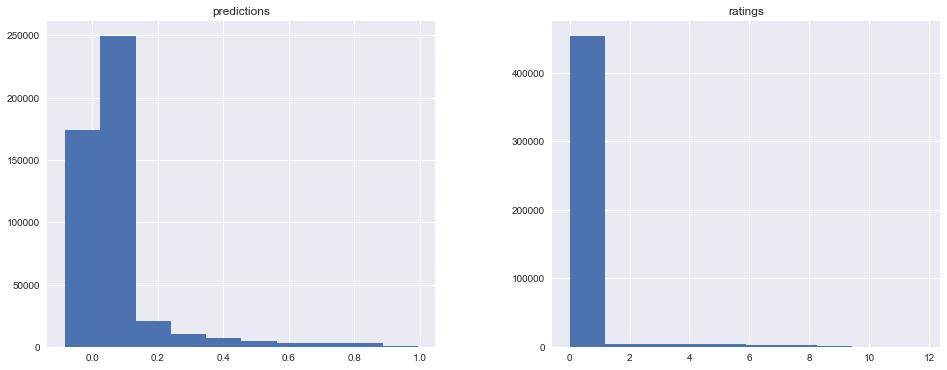

In [210]:
_ = pd.DataFrame({
    'predictions': predictions.values.flatten(),
    'ratings': ratings_df['train_rating'].values.flatten()
}).hist(figsize=(16, 6))

Finally, let's add the artist.

# finally, add the artist in there

In [ ]:
n_artists = ratings_df['song_artist_index'].nunique()

In [ ]:
artist_input = Input(shape=(1,), dtype='int64', name='artist')
artist_embedding = Embedding(input_dim=n_artists, output_dim=F, embeddings_regularizer=l2(lmbda))(artist_input)
dense_artist_embedding = Dense(units=1, activation='relu')(artist_embedding)
dense_artist_embedding = Flatten()(dense_artist_embedding)

predicted_preference_merge = concatenate(inputs=[predicted_preference, dense_title_lstm, dense_artist_embedding])
final_output = Dense(activation='linear', units=1)(predicted_preference_merge)

In [ ]:
model = Model(inputs=[country_input, song_input, title_input, artist_input], outputs=final_output)
model.compile(loss=implicit_cf_loss, optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
inputs = [
    ratings_df['country_index'], 
    ratings_df['song_index'], 
    padded_title_sequences, 
    ratings_df['song_artist_index']
]

model.fit(
    x=inputs,
    y=ratings_df['train_rating'],
    batch_size=256, 
    epochs=10,
    validation_data=(inputs, ratings_df['validation_rating'])
)

In [ ]:
predictions = generate_predictions(model=model, inputs=inputs)
evaluate_predictions(predictions)